In [1]:
# Libraries
import numpy as np
import scipy.io as sio
import os
import pickle
# import re
import ieeg_funcs as ief
import dgFuncs as dg
from sklearn import preprocessing
# from scipy import stats
# from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn import svm, linear_model
from sklearn.metrics import roc_auc_score
from sklearn.externals import joblib
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
import imp 
imp.reload(dg) 

<module 'dgFuncs' from '/Users/davidgroppe/PycharmProjects/DG_LIBRARY/dgFuncs.py'>

In [3]:
# Function for extracting channel names from filename
def chan_labels_from_fname(in_file):
    just_fname=in_file.split('/')[-1]
    jf_splt=just_fname.split('_')
    chan_label=jf_splt[1]+'-'+jf_splt[2]
    return chan_label

In [4]:
# Get size of a subject's data (and filenames)
def data_size_and_fnames(sub_list,ftr_root):
    grand_non_fnames=list()
    grand_szr_fnames=list()
    grand_n_szr_wind=0
    grand_n_non_wind=0
    for sub in sub_list:
        print('Working on sub %d' % sub)
        non_fnames=list()
        szr_fnames=list()
        
        ftr_path=os.path.join(ftr_root,str(sub))
        for f in os.listdir(ftr_path):
            if f.endswith('non.mat'):
                non_fnames.append(os.path.join(ftr_root,str(sub),f))
            elif f.endswith('.mat') and f.startswith(str(sub)+'_'):
                szr_fnames.append(os.path.join(ftr_root,str(sub),f))

        print('%d non-szr files found' % len(non_fnames))
        print('%d szr files found' % len(szr_fnames))  

        # Loop over NON-szr files to get total # of windows
        n_non_wind=0
        ftr_dim=0
        for f in non_fnames:
            temp_ftrs=sio.loadmat(f)
            n_non_wind+=temp_ftrs['nonszr_se_ftrs'].shape[1]
            if ftr_dim==0:
                ftr_dim=temp_ftrs['nonszr_se_ftrs'].shape[0]
            elif ftr_dim!=temp_ftrs['nonszr_se_ftrs'].shape[0]:
                raise ValueError('# of features in file does match previous files')

        print('%d total # of NON-szr time windows for this sub' % n_non_wind)

        # Loop over SZR files to get total # of windows
        n_szr_wind=0
        for f in szr_fnames:
            temp_ftrs=sio.loadmat(f)
            n_szr_wind+=temp_ftrs['se_ftrs'].shape[1]
        print('%d total # of SZR time windows for this sub' % n_szr_wind)
        
        grand_non_fnames+=non_fnames
        grand_szr_fnames+=szr_fnames
        grand_n_szr_wind+=n_szr_wind
        grand_n_non_wind+=n_non_wind
        
    return grand_szr_fnames, grand_non_fnames, grand_n_szr_wind, grand_n_non_wind, ftr_dim

In [10]:
def szr_phat(szr_fnames, non_fnames, models):
    
    # Import non-szr data
    ptr=0
    mns_dict=dict()
    sds_dict=dict()
    for f in non_fnames:
#         print(f)
        chan_label=chan_labels_from_fname(f)

        temp_ftrs=sio.loadmat(f)
        temp_n_wind=temp_ftrs['nonszr_se_ftrs'].shape[1]
        raw_ftrs=temp_ftrs['nonszr_se_ftrs']
        # Z-score features
        temp_mns, temp_sds=dg.trimmed_normalize(raw_ftrs,0,zero_nans=False,verbose=False)
        #temp_mns, temp_sds=dg.trimmed_normalize(raw_ftrs,0.3,zero_nans=False,verbose=False)
        mns_dict[chan_label]=temp_mns
        sds_dict[chan_label]=temp_sds
    
        ftrs[:,ptr:ptr+temp_n_wind]=raw_ftrs
        targ_labels[ptr:ptr+temp_n_wind]=0
        tmp=f.split('/')[-1]
#         print(tmp)
#         print(int(tmp.split('_')[0]))
        sub_ids[ptr:ptr + temp_n_wind] = int(tmp.split('_')[0])
        ptr+=temp_n_wind

    # Import szr data
    for f in szr_fnames:
        chan_label=chan_labels_from_fname(f)

        temp_ftrs=sio.loadmat(f)
        temp_n_wind=temp_ftrs['se_ftrs'].shape[1]
        raw_ftrs=temp_ftrs['se_ftrs']
        # Z-score based on non-ictal means, SDs
        dg.applyNormalize(raw_ftrs,mns_dict[chan_label],sds_dict[chan_label])

        ftrs[:,ptr:ptr+temp_n_wind]=raw_ftrs
        targ_labels[ptr:ptr+temp_n_wind]=1;
        tmp=f.split('/')[-1]
        sub_ids[ptr:ptr + temp_n_wind] = int(tmp.split('_')[0])
        ptr+=temp_n_wind

    return ftrs, targ_labels, sub_ids

In [6]:
# Load saved model
model_stem='genLogregSe_3'
model_fname=os.path.join('/Users/davidgroppe/PycharmProjects/SZR_ANT/MODELS/',model_stem,
                         'classify_models_srch.pkl')
models=pickle.load(open(model_fname,'rb'))
n_models=len(models)
print('# of models= %d' % n_models)
print(type(models[0]))

# of models= 5
<class 'sklearn.linear_model.logistic.LogisticRegression'>


In [11]:
# Load Test Data
#test_subs=[264, 1096, 1125]
test_subs=[264]
ftr_root='/Users/davidgroppe/PycharmProjects/SZR_ANT/EU_GENERAL/EU_GENERAL_FTRS/SE/'
for sub in test_subs:
    szr_fnames_va, non_fnames_va, n_szr_wind_va, n_non_wind_va, ftr_dim=data_size_and_fnames(test_subs, ftr_root)
    ftrs_va, targ_labels_va, sub_id_va=import_data(szr_fnames_va, non_fnames_va, n_szr_wind_va, n_non_wind_va, ftr_dim)
    
    # apply classifier
    for model_ct in range(n_models):
        tmp_yhat_va = models[model_ct].predict_proba(ftrs_va.T)[:,1]
        if model_ct==0:
            class_hat_va=np.zeros(tmp_yhat_va.shape)
        class_hat_va+=tmp_yhat_va/n_models

Working on sub 264
18 non-szr files found
25 szr files found
17500 total # of NON-szr time windows for this sub
16244 total # of SZR time windows for this sub
/Users/davidgroppe/PycharmProjects/SZR_ANT/EU_GENERAL/EU_GENERAL_FTRS/SE/264/264_BLA1_BLA2_non.mat
/Users/davidgroppe/PycharmProjects/SZR_ANT/EU_GENERAL/EU_GENERAL_FTRS/SE/264/264_BLB1_BLB2_non.mat
/Users/davidgroppe/PycharmProjects/SZR_ANT/EU_GENERAL/EU_GENERAL_FTRS/SE/264/264_BLB2_BLB3_non.mat
/Users/davidgroppe/PycharmProjects/SZR_ANT/EU_GENERAL/EU_GENERAL_FTRS/SE/264/264_BLC1_BLC2_non.mat
/Users/davidgroppe/PycharmProjects/SZR_ANT/EU_GENERAL/EU_GENERAL_FTRS/SE/264/264_BLC2_BLC3_non.mat
/Users/davidgroppe/PycharmProjects/SZR_ANT/EU_GENERAL/EU_GENERAL_FTRS/SE/264/264_BLC3_BLC4_non.mat
/Users/davidgroppe/PycharmProjects/SZR_ANT/EU_GENERAL/EU_GENERAL_FTRS/SE/264/264_BLC4_BLC5_non.mat
/Users/davidgroppe/PycharmProjects/SZR_ANT/EU_GENERAL/EU_GENERAL_FTRS/SE/264/264_BRA1_BRA2_non.mat
/Users/davidgroppe/PycharmProjects/SZR_ANT/EU_GEN

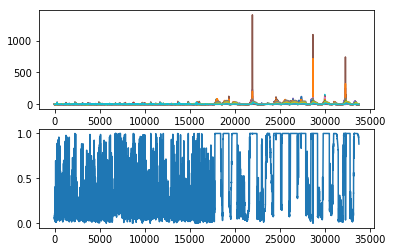

In [9]:
plt.figure(1)
plt.subplot(2,1,1)
plt.plot(ftrs_va.T);

plt.subplot(2,1,2)
plt.plot(class_hat_va);


In [18]:
bro=np.load('/Users/davidgroppe/PycharmProjects/SZR_ANT/MODELS/genLogregSe_9/classify_metrics_srch.npz')

In [20]:
print(bro.keys())
print(bro['best_valid_bal_acc'])
print(bro['best_train_bal_acc'])

['ftr_types', 'train_bal_acc', 'gamma_vals', 'best_train_bal_acc', 'valid_sens', 'best_gam', 'left_out_id', 'train_subs_list', 'best_valid_bal_acc_by_sub', 'tried_C', 'train_sens', 'best_models', 'tried_valid_acc', 'valid_spec', 'best_valid_bal_acc', 'mn_stim_latency', 'rand_ct', 'tried_train_acc', 'tried_gamma', 'train_spec', 'best_C', 'valid_bal_acc', 'pptn_preonset_stim', 'n_train_steps', 'pptn_missed_szrs', 'C_vals']
0.8372262211982854
0.8683258901503061


In [24]:
#print(10**np.linspace(-1.5,-1,5))
print(10**np.linspace(-2,0,5))
print(10**0)

[ 0.03162278  0.04216965  0.05623413  0.07498942  0.1       ]
[ 0.01        0.03162278  0.1         0.31622777  1.        ]
1


In [ ]:
# Evaluate ensemble of models on validation data
for model_ct in range(n_models):
    tmp_yhat_va = models[model_ct].predict_proba(ftrs_va.T)[:,1]
    if model_ct==0:
        class_hat_va=np.zeros(tmp_yhat_va.shape)
    class_hat_va+=tmp_yhat_va/n_models
    
print('Validation Data Performance')
auc_va=roc_auc_score(targ_labels_va, class_hat_va)
print('AUC=%.3f' % auc_va)
bal_acc_va, sens_va, spec_va=ief.perf_msrs(targ_labels_va, class_hat_va>=0.5)
print('Balanced Accuracy (sens/spec)=%.3f (%f/%f)' % (bal_acc_va,sens_va,spec_va))

In [ ]:
min_ftrs=np.min(ftrs_va)
plt.figure(11)
plt.clf()
plt.plot(np.log10(1-min_ftrs+ftrs_va.T));
plt.title('Validation Data')

plt.figure(12)
plt.clf()
plt.plot(targ_labels_va,'b-');
plt.plot(class_hat_va,'r.');

In [ ]:
from sklearn.metrics import roc_curve, auc
#fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
fpr, tpr, thresh = roc_curve(targ_labels_va, class_hat_va)
plt.figure(3)
lw = 2
plt.plot(fpr, tpr, 'r-.',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_va)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

plt.figure(4)
mn=(tpr+(1-fpr))/2
mx_mn_id=np.argmax(mn)
plt.plot(thresh,mn,'.-')
plt.plot(thresh[mx_mn_id],mn[mx_mn_id],'ro')
print('Ideal threshold=%f' % thresh[mx_mn_id])
print('Corresponding sens/spec=%f/%f' % (tpr[mx_mn_id],1-fpr[mx_mn_id]))
bal_acc_va, sens_va, spec_va=ief.perf_msrs(targ_labels_va, class_hat_va>=thresh[mx_mn_id])
print('Balanced Accuracy (sens/spec)=%.3f (%f/%f)' % (bal_acc_va,sens_va,spec_va))
# J=sens+spec-1